In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

In [2]:
%run -i financial_sector_functions.py

/home/luke/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [4]:
data = pd.read_csv("financial_sector_clean_return_space.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)

sector_return = data.iloc[:,[0]]
x_data = pd.concat([data.iloc[:,1:],sp500],1)

sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

In [5]:
sector_beat_benchmarks = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index, columns = sector_return.columns)

In [16]:
def logistic_fit_function(x,y,nunmber_of_years_lookback,month_forecast,lambda_value,penalty_type ='l2'):
    logistic_result_dict = {}
    coef_all_df = pd.DataFrame()
    accuracy_dict = {}
    y_prediction_dict ={}
    number_of_runs = 0.0
    for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
        begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
        selection = (x.index>=begin_index) & (x.index <= end_index)
        spliced_x = x[selection]
        spliced_y = y[selection]

        assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
        logistic  = LogisticRegression(penalty=penalty_type, C = 1/float(lambda_value))
        logistic.fit(spliced_x,spliced_y)

        test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
        test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
        test_x = x[test_selection]
        test_y = y[test_selection]
        assert(len(test_y)==month_forecast)
        y_prediction = pd.DataFrame(logistic.predict(test_x),index = test_y.index,columns = test_y.columns)

        y_prediction_dict[dt_index] = y_prediction
        accuracy_df = ((y_prediction-test_y)==0)*1
        accuracy_dict[dt_index] = accuracy_df
        number_of_runs +=1

    mean_accuracy_list = []
    for key,value in accuracy_dict.iteritems():
        mean_accuracy_list.append((value.values.flatten()))
    return np.mean(mean_accuracy_list)

array([  0.1,   1.2,   2.3,   3.4,   4.5,   5.6,   6.7,   7.8,   8.9,  10. ])

In [35]:

nunmber_of_years_lookback = 10
month_forecast = 3

forecast_3m = pd.DataFrame()
for years in range(3,11):
    for lambda_value in np.linspace(0.1,10,10):
        accuracy = logistic_fit_function(x=x_data,y=sector_beat_benchmarks
                                         ,nunmber_of_years_lookback = years,
                                         month_forecast = 3,lambda_value = lambda_value)
        forecast_3m.loc[str(years)+' years',str(lambda_value)]=accuracy

In [40]:
print(np.max(forecast_3m.values))
np.round(forecast_3m,3)

0.58024691358


,0.1,1.2,2.3,3.4,4.5,5.6,6.7,7.8,8.9,10.0
3 years,0.570,0.562,0.568,0.566,0.566,0.568,0.570,0.568,0.570,0.570
4 years,0.574,0.567,0.574,0.571,0.574,0.576,0.571,0.569,0.567,0.565
5 years,0.568,0.578,0.580,0.580,0.580,0.578,0.570,0.568,0.563,0.565
6 years,0.580,0.526,0.528,0.528,0.531,0.531,0.531,0.534,0.531,0.531
7 years,0.550,0.550,0.553,0.550,0.550,0.550,0.550,0.547,0.547,0.544
8 years,0.556,0.545,0.549,0.545,0.545,0.535,0.532,0.532,0.532,0.532
9 years,0.548,0.567,0.567,0.567,0.571,0.563,0.559,0.556,0.556,0.552
10 years,0.493,0.529,0.524,0.524,0.524,0.520,0.520,0.524,0.533,0.533


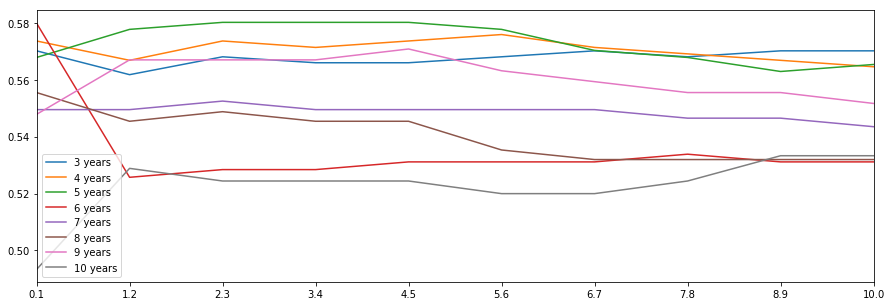

In [51]:
fig_size = 15,5
forecast_3m.T.plot(figsize = fig_size)
plt.show()

In [15]:
def change_month_horizon(x,y,month_looking_forward):
    forecast_df = pd.DataFrame()
    for years in range(3,11):
        for lambda_value in np.linspace(0.1,10,10):
            accuracy = logistic_fit_function(x=x,y=y,
                                             nunmber_of_years_lookback = years,
                                             month_forecast = month_looking_forward,
                                             lambda_value = lambda_value)
            forecast_df.loc[str(years)+' years',str(lambda_value)]=accuracy
            
    fig_size = 15,5
    forecast_df.T.plot(figsize = fig_size)
    plt.show()
    print(month_looking_forward)
    print(np.round(np.max(forecast_df.values),3))

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

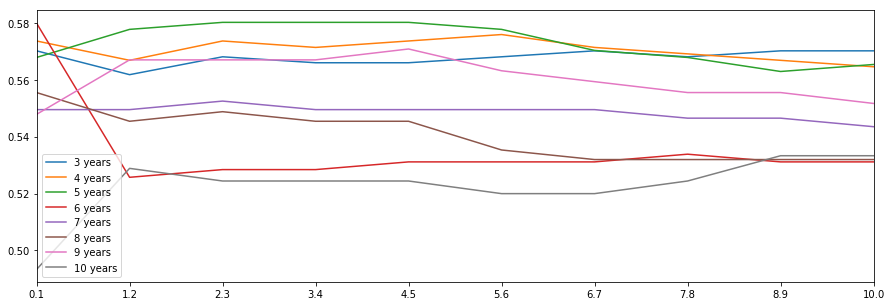

3
0.58


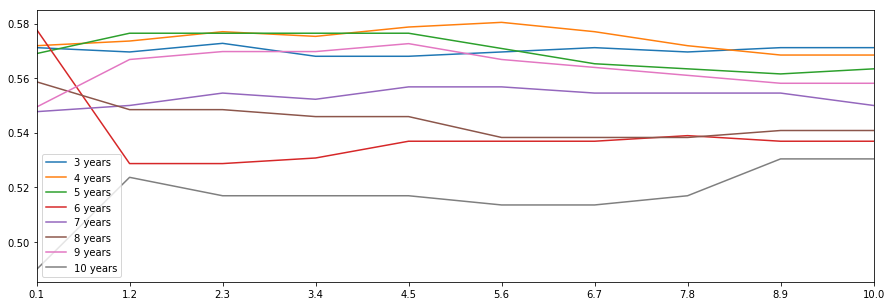

4
0.58


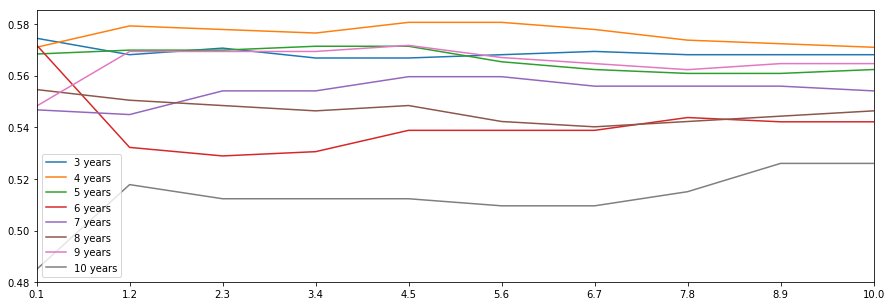

5
0.581


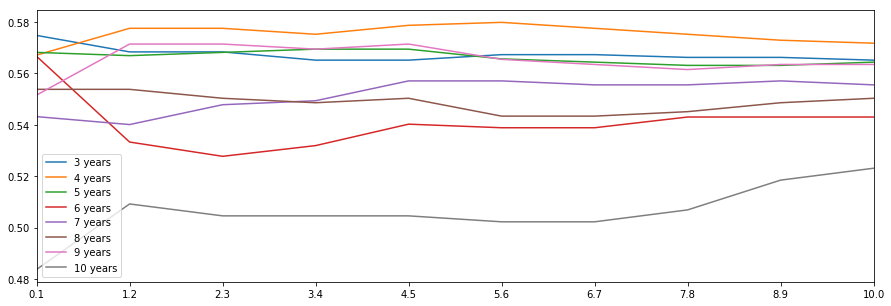

6
0.58


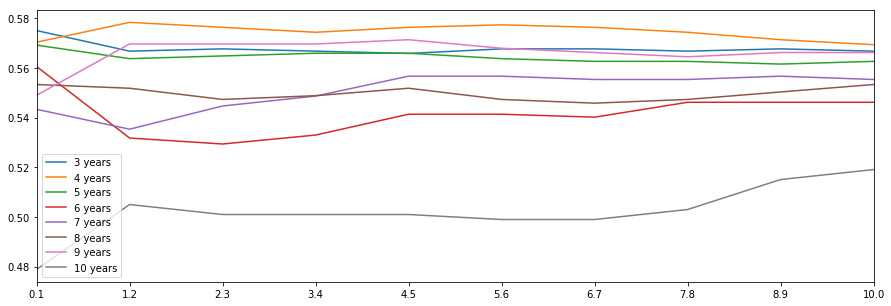

7
0.578


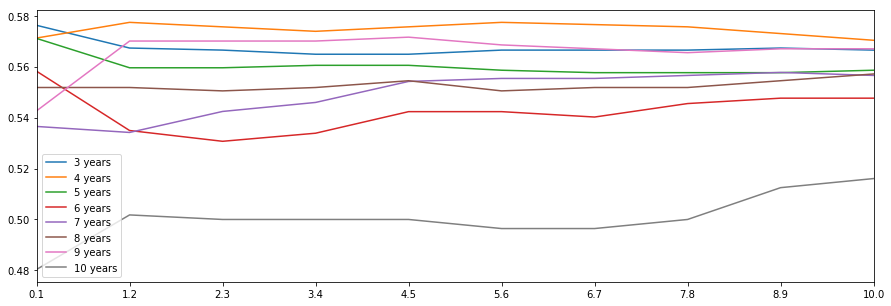

8
0.577


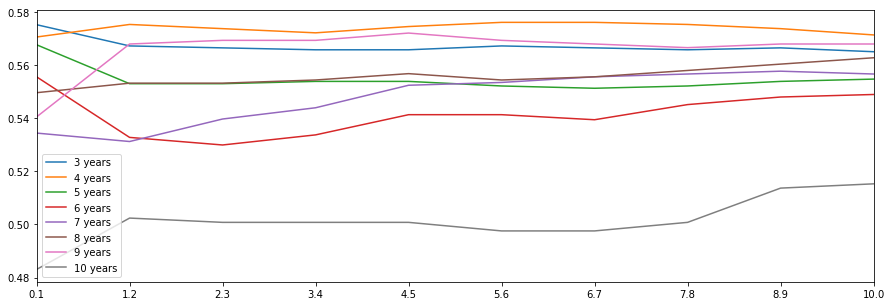

9
0.576


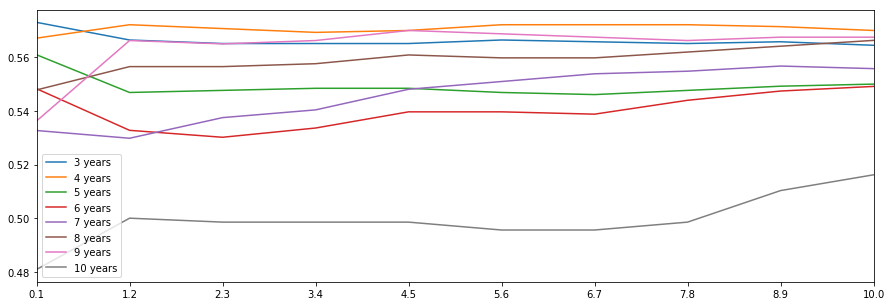

10
0.573


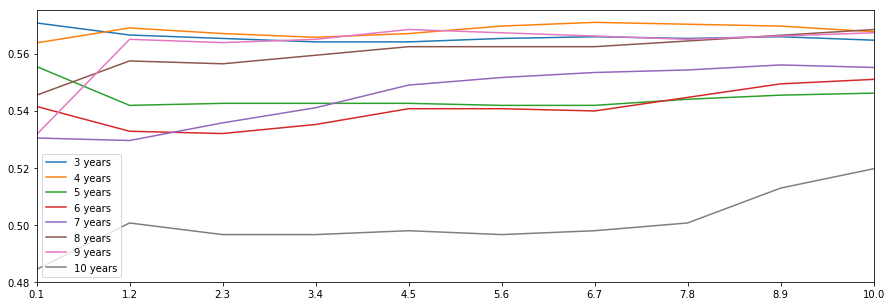

11
0.571


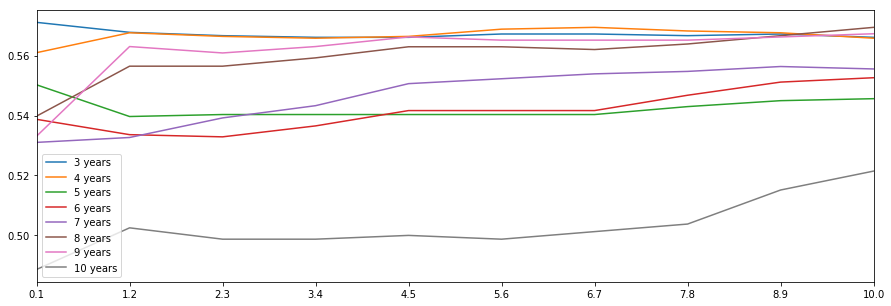

12
0.571


In [61]:
for month in np.arange(3,12+1):
    change_month_horizon(x_data,sector_beat_benchmarks,month)

In [9]:
%store -r equal_weight_momentum
%store -r market_cap_weight_momentum

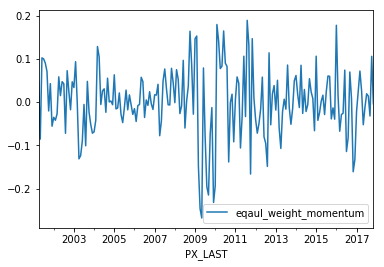

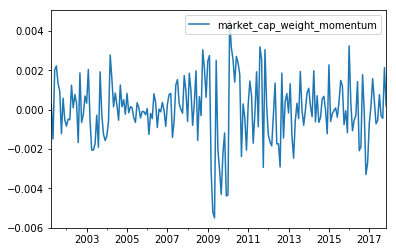

In [62]:
equal_weight_momentum.plot()
market_cap_weight_momentum.plot()
plt.show()

/home/luke/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


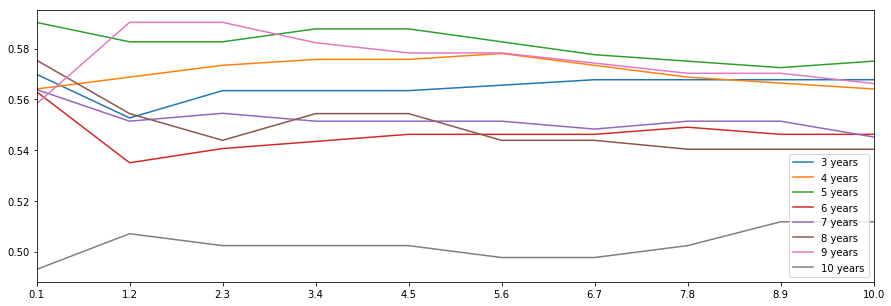

3
0.59


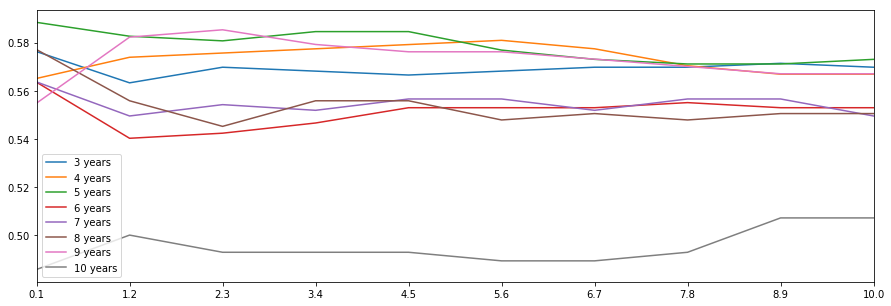

4
0.588


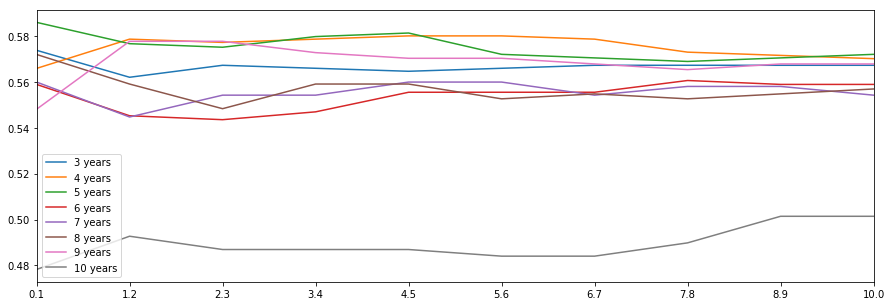

5
0.586


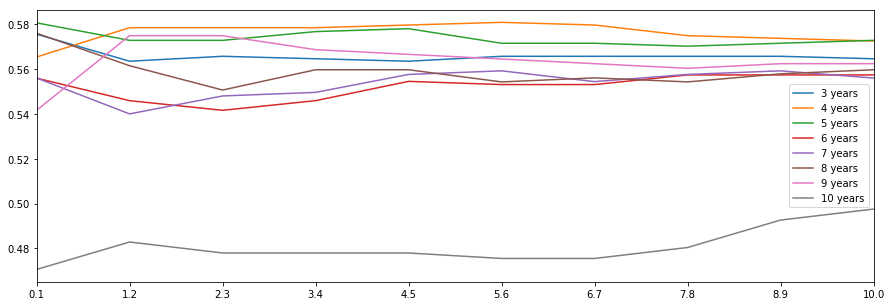

6
0.581


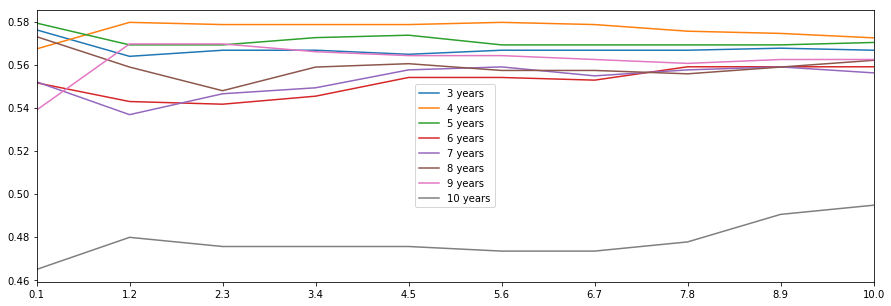

7
0.58


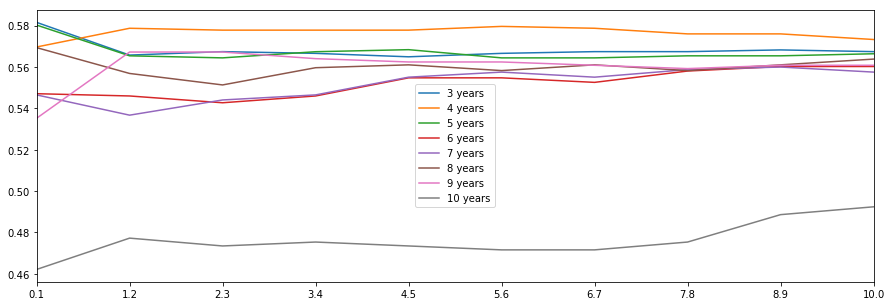

8
0.582


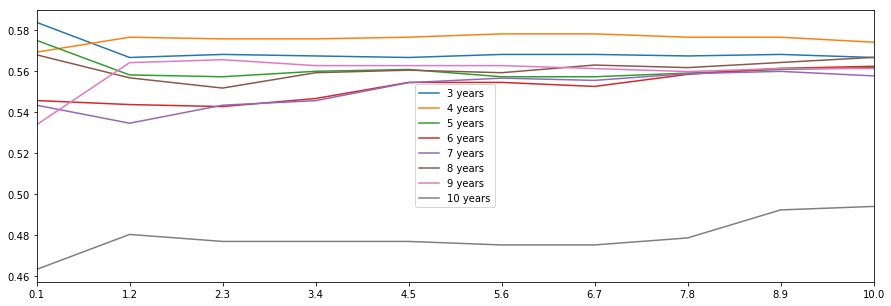

9
0.584


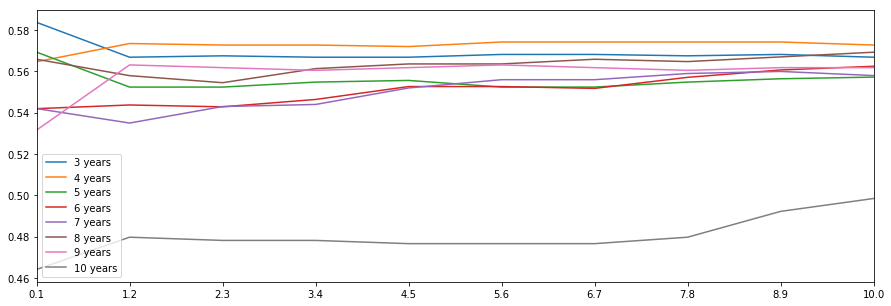

10
0.584


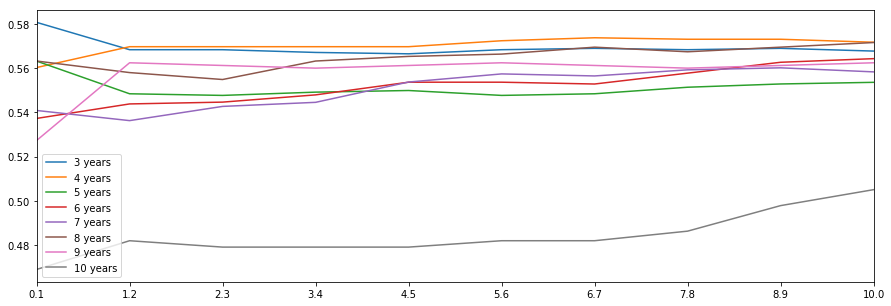

11
0.581


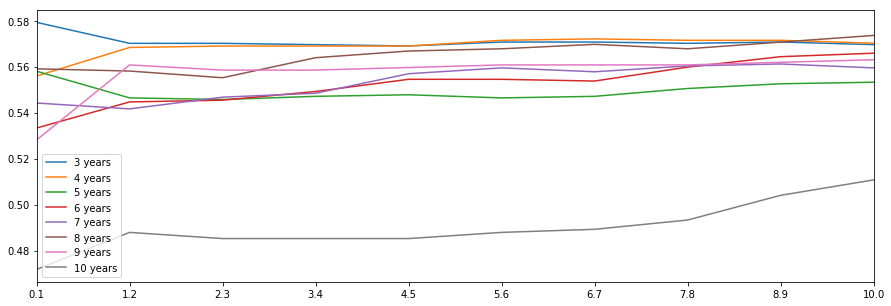

12
0.579


In [17]:
x_data_momentum = pd.concat([equal_weight_momentum,x_data],1).resample("M").last().dropna()
sector_beat_benchmarks = sector_beat_benchmarks.resample("M").last().dropna()
x_data_momentum,sector_beat_benchmarks = model_data(x_data_momentum,sector_beat_benchmarks)
for month in np.arange(3,12+1):
    change_month_horizon(x_data_momentum,sector_beat_benchmarks,month)

In [22]:
market_cap_weight_momentum,x_data = model_data(market_cap_weight_momentum,x_data)

In [23]:
market_cap_weight_momentum.resample("M").last().dropna().index

DatetimeIndex(['2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31',
               '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30',
               '2001-12-31', '2002-01-31',
               ...
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30'],
              dtype='datetime64[ns]', length=192, freq=None)

In [24]:
x_data.resample("M").last().dropna().index

DatetimeIndex(['2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31',
               '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30',
               '2001-12-31', '2002-01-31',
               ...
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30'],
              dtype='datetime64[ns]', length=192, freq=None)

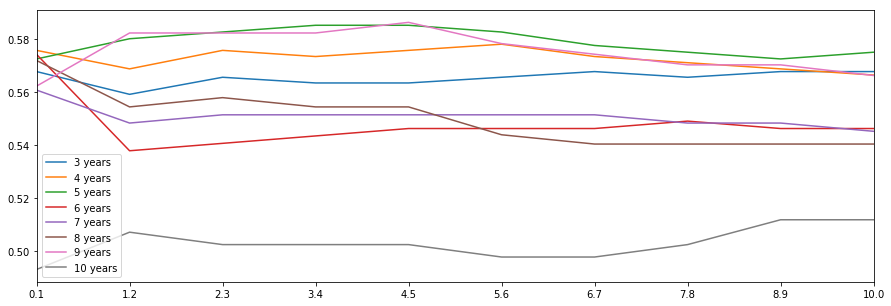

3
0.586


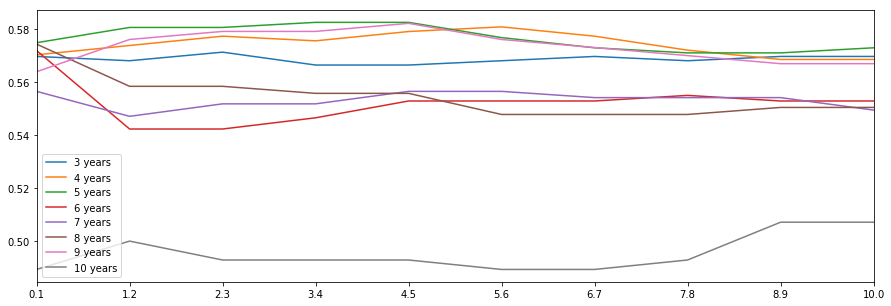

4
0.583


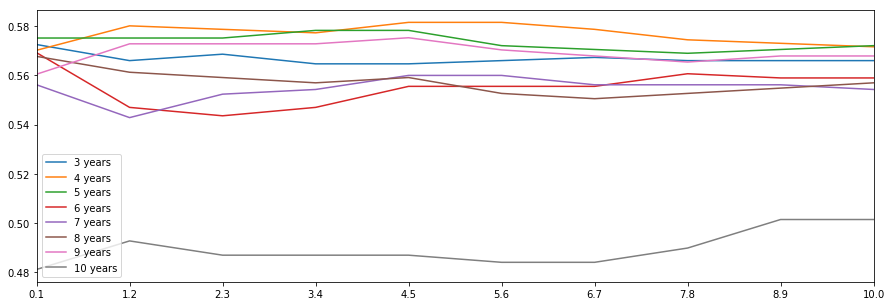

5
0.582


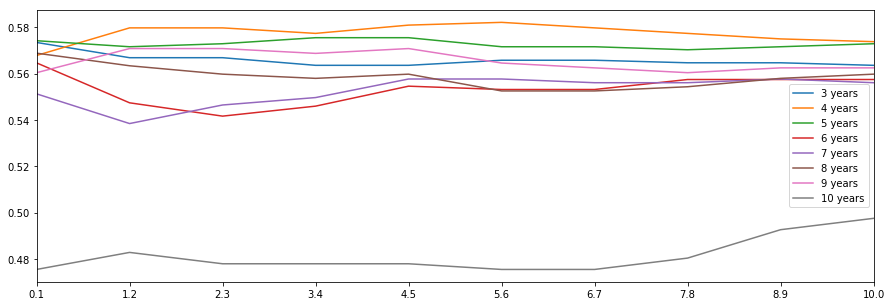

6
0.582


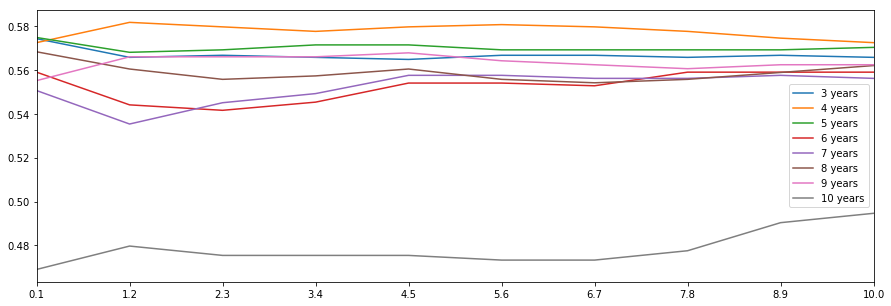

7
0.582


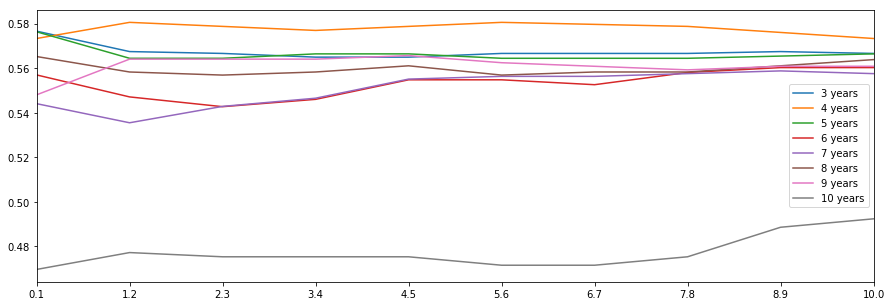

8
0.581


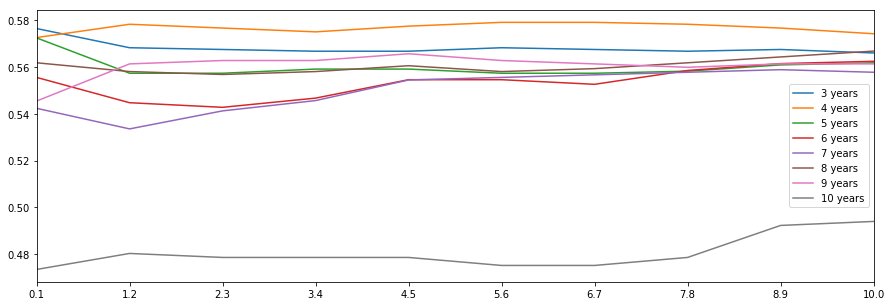

9
0.579


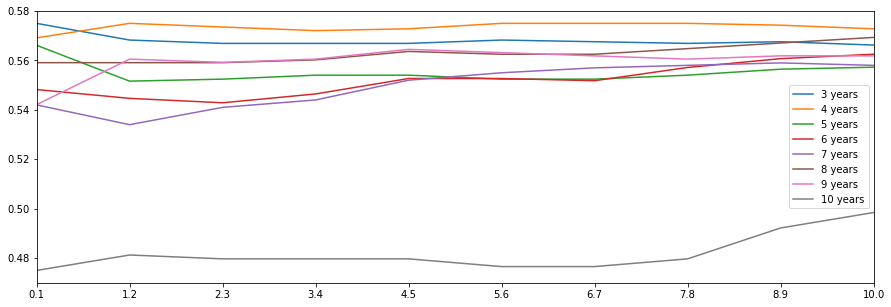

10
0.575


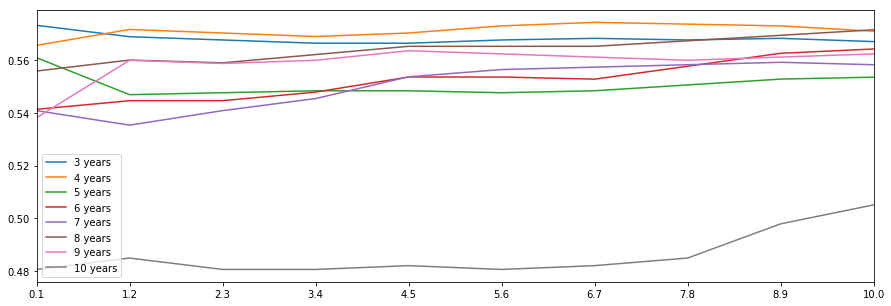

11
0.574


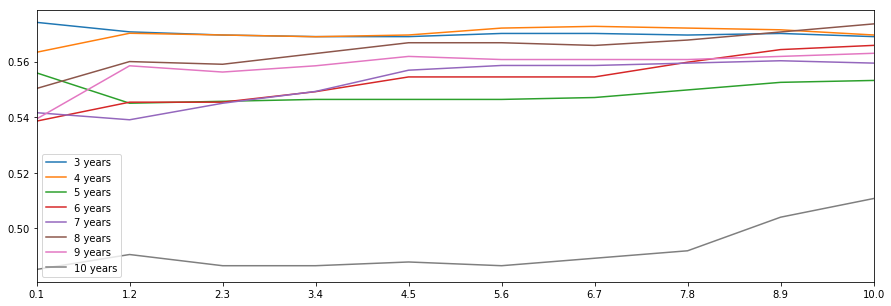

12
0.574


In [18]:
x_data_cap_momentum = pd.concat([market_cap_weight_momentum,x_data],1).resample("M").last().dropna()
x_data_cap_momentum,sector_beat_benchmarks = model_data(x_data_cap_momentum,sector_beat_benchmarks)
for month in np.arange(3,12+1):
    change_month_horizon(x_data_cap_momentum,sector_beat_benchmarks,month)